XGBoost Eğitim R^2 Skoru: 0.7106982245832826
XGBoost Doğrulama R^2 Skoru: 0.6255317791995669
Doğruluk Skoru: 0.9314271868185122
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3075
           1       0.92      0.80      0.86      1052

    accuracy                           0.93      4127
   macro avg       0.93      0.89      0.91      4127
weighted avg       0.93      0.93      0.93      4127



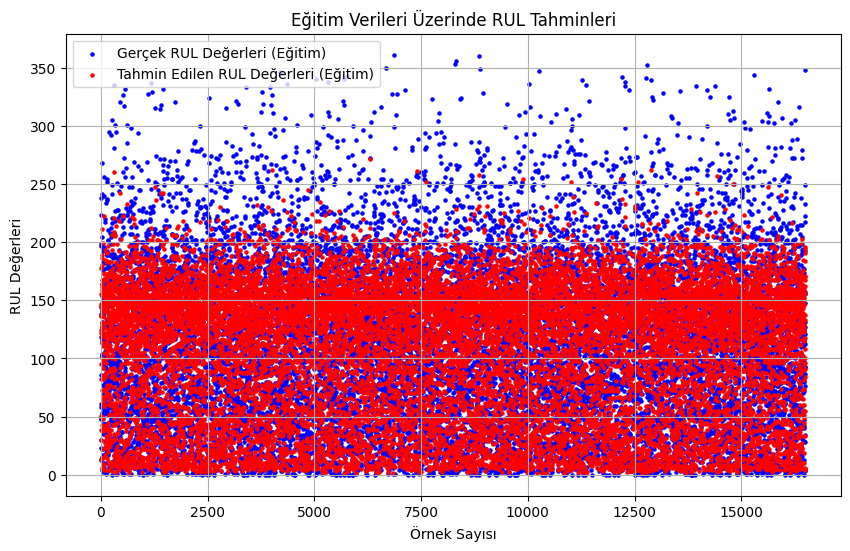

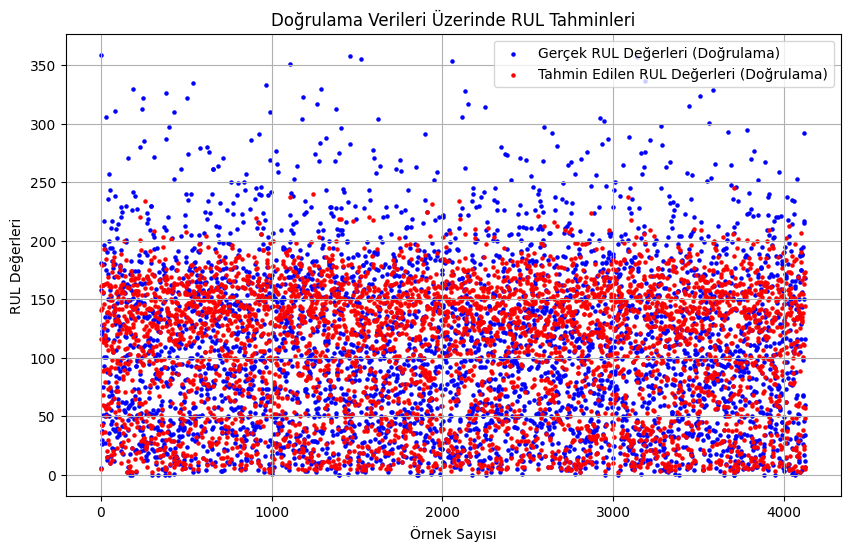

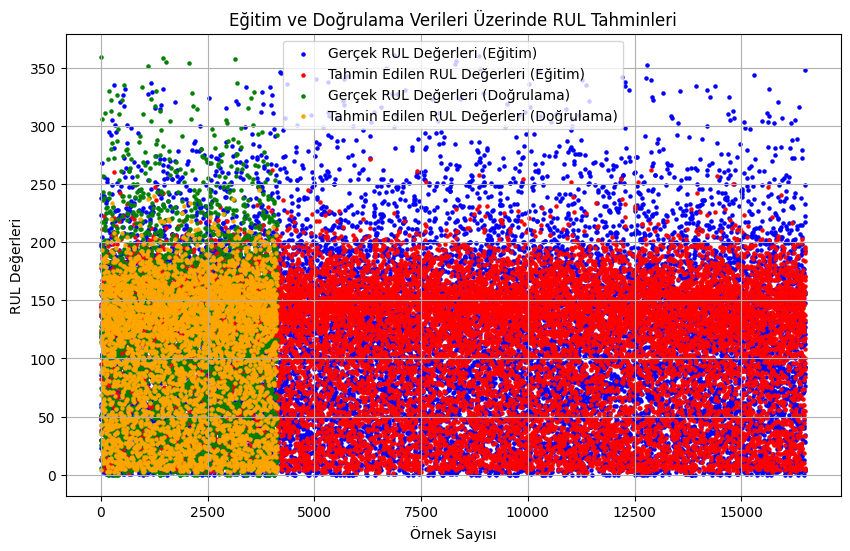

Gerçek RUL ile Tahmin Edilen RUL Değerleri Arasındaki Ortalama Mutlak Hata (MAE): 25.525955691337586


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Veri okuma ve işleme
index_isimleri = ['birim_no', 'zaman_döngüleri']
ayar_isimleri = ['ayar_1', 'ayar_2', 'ayar_3']
sensör_isimleri = ['sensör_{}'.format(i) for i in range(1, 22)]
kolon_isimleri = index_isimleri + ayar_isimleri + sensör_isimleri

egitim = pd.read_csv(r"D:\users\m_ozdemir15\Desktop\Okul\Y.Lisans\2.Dönem\Makine Öğrenmesi\Proje\cmapss\train_FD001.txt", sep='\s+', header=None, names=kolon_isimleri)
test = pd.read_csv(r"D:\users\m_ozdemir15\Desktop\Okul\Y.Lisans\2.Dönem\Makine Öğrenmesi\Proje\cmapss\test_FD001.txt", sep='\s+', header=None, names=kolon_isimleri)
y_test = pd.read_csv(r"D:\users\m_ozdemir15\Desktop\Okul\Y.Lisans\2.Dönem\Makine Öğrenmesi\Proje\cmapss\RUL_FD001.txt", sep='\s+', header=None, names=['RUL'])

def geriye_kalan_kullanılabilir_ömür_ekle(df):
    # Boş bir DataFrame oluştur
    sonuç_cercevesi = pd.DataFrame()

    # Her bir birim (unit) için RUL hesaplamalarını yap
    for birim_no, grup in df.groupby("birim_no"):
        maksimum_döngü = grup["zaman_döngüleri"].max()
        grup["RUL"] = maksimum_döngü - grup["zaman_döngüleri"]
        sonuç_cercevesi = pd.concat([sonuç_cercevesi, grup])

    return sonuç_cercevesi

# Veriyi hazırla
egitim = geriye_kalan_kullanılabilir_ömür_ekle(egitim)

atılacak_kolonlar = index_isimleri + ayar_isimleri
# Sadece sensör verileri dışındaki sütunları bırak
X_egitim = egitim.drop(atılacak_kolonlar, axis=1)
y_egitim = X_egitim.pop('RUL') #eğitim veri çerçevesinden "RUL" (Kalan Kullanılabilir Ömür) sütununu çıkararak bu sütunu ayrı bir değişkene (y_egitim) ata

# Test verileri için RUL değerleri sadece her motorun son zaman döngüsünde verildiği için test verilerini ayarla
X_test = test.groupby('birim_no').last().reset_index().drop(atılacak_kolonlar, axis=1)

# Veri bölünmelerini oluştur
X_egitim, X_doğrulama, y_egitim, y_doğrulama = train_test_split(X_egitim, y_egitim, test_size=0.2)

# XGBoost modeli oluştur
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.2,  # Öğrenme oranı
    max_depth=4,  # Ağaç derinliği
    min_child_weight=1,  # Yaprak düğümünde minimum çocuk ağırlığı
    gamma=0,  # Düğüm bölünmesi için gereken minimum kayıp azalma
    subsample=0.8,  # Veri örneklemesi
    colsample_bytree=0.8,  # Ağaç oluştururken sütun örnekleme
    objective='reg:squarederror',  # Regresyon görevi
    random_state=0
)

# Modeli eğitin
xgb_model.fit(X_egitim, y_egitim)

# Eğitim verileri üzerinde tahminler yap
y_egitim_tahmin_xgb = xgb_model.predict(X_egitim)

# Doğrulama verileri üzerinde tahminler yap
y_doğrulama_tahmin_xgb = xgb_model.predict(X_doğrulama)

# Eğitim ve doğrulama için R^2 skorlarını hesapla
egitim_r2_skoru = r2_score(y_egitim, y_egitim_tahmin_xgb)
doğrulama_r2_skoru = r2_score(y_doğrulama, y_doğrulama_tahmin_xgb)

# R^2 skorlarını yazdır
print(f"XGBoost Eğitim R^2 Skoru: {egitim_r2_skoru}")
print(f"XGBoost Doğrulama R^2 Skoru: {doğrulama_r2_skoru}")

# Eşik değerini tanımla
eşik_değeri = 50

# RUL değerlerini sınıflandır
y_egitim_sınıflandırma = (y_egitim <= eşik_değeri).astype(int)
y_doğrulama_sınıflandırma = (y_doğrulama <= eşik_değeri).astype(int)

# Doğrulama verileri için doğruluk skorunu ve sınıflandırma raporunu hesapla
doğruluk = accuracy_score(y_doğrulama_sınıflandırma, xgb_model.predict(X_doğrulama) <= eşik_değeri)
rapor = classification_report(y_doğrulama_sınıflandırma, xgb_model.predict(X_doğrulama) <= eşik_değeri)

print(f"Doğruluk Skoru: {doğruluk}")
print("Sınıflandırma Raporu:")
print(rapor)

# Eğitim ve doğrulama verileri üzerinde tahmin edilen RUL değerlerini alın
y_egitim_tahmin_xgb = xgb_model.predict(X_egitim)
y_doğrulama_tahmin_xgb = xgb_model.predict(X_doğrulama)

# Eğitim ve doğrulama verileri için gerçek RUL değerlerini alın
y_egitim_gerçek = y_egitim
y_doğrulama_gerçek = y_doğrulama

# Eğitim verileri için gerçek ve tahmin edilen RUL değerlerini nokta grafiklerle karşılaştırın
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_egitim_gerçek)), y_egitim_gerçek, label='Gerçek RUL Değerleri (Eğitim)', color='blue', s=5)
plt.scatter(range(len(y_egitim_tahmin_xgb)), y_egitim_tahmin_xgb, label='Tahmin Edilen RUL Değerleri (Eğitim)', color='red', s=5)
plt.title('Eğitim Verileri Üzerinde RUL Tahminleri')
plt.xlabel('Örnek Sayısı')
plt.ylabel('RUL Değerleri')
plt.legend()
plt.grid(True)
plt.show()

# Doğrulama verileri için gerçek ve tahmin edilen RUL değerlerini nokta grafiklerle karşılaştırın
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_doğrulama_gerçek)), y_doğrulama_gerçek, label='Gerçek RUL Değerleri (Doğrulama)', color='blue', s=5)
plt.scatter(range(len(y_doğrulama_tahmin_xgb)), y_doğrulama_tahmin_xgb, label='Tahmin Edilen RUL Değerleri (Doğrulama)', color='red', s=5)
plt.title('Doğrulama Verileri Üzerinde RUL Tahminleri')
plt.xlabel('Örnek Sayısı')
plt.ylabel('RUL Değerleri')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_egitim_gerçek)), y_egitim_gerçek, label='Gerçek RUL Değerleri (Eğitim)', color='blue', s=5)
plt.scatter(range(len(y_egitim_tahmin_xgb)), y_egitim_tahmin_xgb, label='Tahmin Edilen RUL Değerleri (Eğitim)', color='red', s=5)
plt.scatter(range(len(y_doğrulama_gerçek)), y_doğrulama_gerçek, label='Gerçek RUL Değerleri (Doğrulama)', color='green', s=5)
plt.scatter(range(len(y_doğrulama_tahmin_xgb)), y_doğrulama_tahmin_xgb, label='Tahmin Edilen RUL Değerleri (Doğrulama)', color='orange', s=5)
plt.title('Eğitim ve Doğrulama Verileri Üzerinde RUL Tahminleri')
plt.xlabel('Örnek Sayısı')
plt.ylabel('RUL Değerleri')
plt.legend()
plt.grid(True)
plt.show()

# RUL değerlerini tahmin et
y_test_tahmin_xgb = xgb_model.predict(X_test)

# Gerçek RUL değerleri ile tahmin edilen RUL değerleri arasındaki karşılaştırma
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_test_tahmin_xgb)
print(f"Gerçek RUL ile Tahmin Edilen RUL Değerleri Arasındaki Ortalama Mutlak Hata (MAE): {mae}")




